# Question Pairs

## Business Problem Context

Given an FAQ database, if we can match a new question to the closest known question, within some threshold of certainty, we can provide a known answer to this new question.

Therefore, a key capability in a knowledge application is the ability to determine the similarity between two questions.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
from sklearn.metrics import accuracy_score, log_loss
from sklearn.model_selection import train_test_split
import sys
%matplotlib inline

In [3]:
sys.path.append('../..')
sys.path.append('/Users/d777710/src/Python/spaCy')
sys.path.append('/Users/d777710/src/Python/spaCy/examples/keras_parikh_entailment')

In [4]:
import keras_model.decomposable_attention as dec_attn
import keras_model.decomposable_attention.util as dec_attn_util

Using TensorFlow backend.


## Dataset - Quora Question Pairs

A dataset created for a [Kaggle competition](https://www.kaggle.com/c/quora-question-pairs).

* Duplicates proportion: 36.9% in train, 17.4% in test
* Number of question pairs: ~400k in train, ~2.3M in test
* ~80% of test dataset contains fake question pairs, such that we can’t hand label test question pairs (avoid cheating)
* ~530k unique questions in train dataset
* ~110k questions appear multiple times in train and test datasets
* Questions which contains:
  * Question mark: 99.87%
  * [math] tags: 0.12%
  * Capitalized first letter: 99.81%
  * Capital letters: 99.95%
  * Numbers: 11.83%

In [5]:
train_df, _ = dec_attn.load_question_pairs_dataset()

In [5]:
train_df.head()

,qid1,qid2,question1,question2,is_duplicate
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [6]:
q1_lens = train_df.question1.apply(lambda x: len(re.split(r'\s+', x.strip()))).values
q2_lens = train_df.question2.apply(lambda x: len(re.split(r'\s+', x.strip()))).values
train_df = train_df.assign(q1_len=q1_lens, q2_len=q2_lens)
lens = np.vstack([q1_lens, q2_lens])

In [7]:
max_len = lens.max()
print('max_len:', max_len)

max_len: 237


In [8]:
max(q1_lens)

125

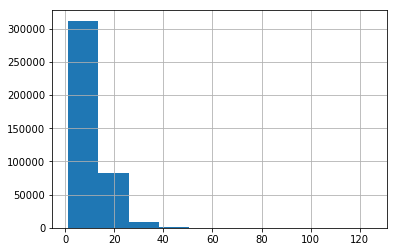

In [9]:
train_df.q1_len.hist()

In [10]:
max(q2_lens)

237

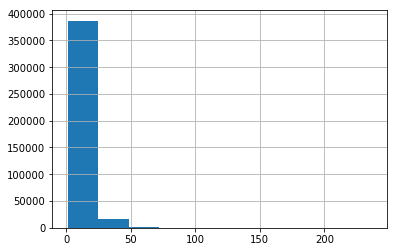

In [11]:
train_df.q2_len.hist()

In [12]:
bins = [5, 10, 20, 30, 40, 50, 60, 70, 100, 228]
train_df = train_df.assign(q1_binned=pd.cut(train_df.q1_len, bins), q2_binned=pd.cut(train_df.q2_len, bins))

In [13]:
train_df.groupby(train_df.q1_binned).size()

q1_binned
(5, 10]       206598
(10, 20]      140015
(20, 30]       22738
(30, 40]        2302
(40, 50]         481
(50, 60]         141
(60, 70]          38
(70, 100]          6
(100, 228]         1
dtype: int64

In [14]:
train_df.groupby(train_df.q2_binned).size()

q2_binned
(5, 10]       207437
(10, 20]      132639
(20, 30]       25853
(30, 40]        3879
(40, 50]         725
(50, 60]         554
(60, 70]         128
(70, 100]         31
(100, 228]        16
dtype: int64

In [15]:
train_df.head(10)

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_binned,q2_binned
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12,"(10, 20]","(10, 20]"
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8,13,"(5, 10]","(10, 20]"
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14,10,"(10, 20]","(5, 10]"
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11,9,"(10, 20]","(5, 10]"
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13,7,"(10, 20]","(5, 10]"
5,11,12,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,16,16,"(10, 20]","(10, 20]"
6,13,14,Should I buy tiago?,What keeps childern active and far from phone ...,0,4,11,NaN,"(10, 20]"
7,15,16,How can I be a good geologist?,What should I do to be a great geologist?,1,7,9,"(5, 10]","(5, 10]"
8,17,18,When do you use シ instead of し?,"When do you use ""&"" instead of ""and""?",0,8,8,"(5, 10]","(5, 10]"
9,19,20,Motorola (company): Can I hack my Charter Moto...,How do I hack Motorola DCX3400 for free internet?,0,9,9,"(5, 10]","(5, 10]"


In [16]:
embeddings, word2idx, _, _ = dec_attn.load_embeddings('../../keras_model/decomposable_attention/ft.vec')

In [17]:
train_df = dec_attn.preprocess(train_df, word2idx, max_len)

In [18]:
train_df.head()

,qid1,qid2,question1,question2,is_duplicate,q1_len,q2_len,q1_binned,q2_binned,q1_encoded,q1_length,q2_encoded,q2_length
0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0,14,12,"(10, 20]","(10, 20]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12
1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0,8,13,"(5, 10]","(10, 20]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13
2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0,14,10,"(10, 20]","(5, 10]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",14,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10
3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0,11,9,"(10, 20]","(5, 10]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",11,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9
4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0,13,7,"(10, 20]","(5, 10]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",13,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7


In [19]:
train_df.iloc[0].question1

'What is the step by step guide to invest in share market in india?'

In [20]:
print(train_df.iloc[0].q1_encoded[-20:])

[0, 0, 0, 0, 0, 0, 103, 104, 102, 1516, 156, 1516, 3425, 107, 615, 109, 851, 698, 109, 882]


In [21]:
counts_by_label = train_df.groupby('is_duplicate').qid1.count()

In [22]:
counts_by_label

is_duplicate
0    255027
1    149263
Name: qid1, dtype: int64

In [23]:
counts_by_label.loc[1] / counts_by_label.sum()

0.369197853026293

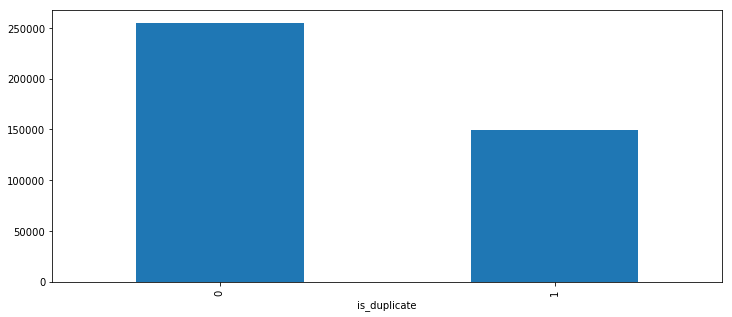

In [24]:
fig = plt.figure(figsize=(12, 5))
ax = plt.axes()
counts_by_label.plot.bar(ylim=0)

In [10]:
train_df, test_df = train_test_split(train_df, test_size=0.1, shuffle=True)

In [20]:
max_len = 60

In [21]:
dec_attn_embeddings_path = '../../keras_model/decomposable_attention/ft.vec'
embeddings, word2idx, _, _ = dec_attn_util.load_embeddings(dec_attn_embeddings_path)

In [22]:
test_df = dec_attn_util.preprocess(test_df, word2idx, max_len)

## Experiment 1 - Decomposable Attention Model

We can think of question similarity as an entailment task.

Textual entailment (TE) in natural language processing is a directional relation between text fragments. The relation holds whenever the truth of one text fragment follows from another text. In the TE framework, the entailing and entailed texts are termed text (t) (or premise (p)) and hypothesis (h), respectively.

The winning solution to the Quora challenge ended up using a decomposable attention model, a siamese network, an enhanced sequential inference model, and more. These were stacked together to form the final classifier.

This model architecture from [A Decomposable Attention Model for Natural Language Inference](https://arxiv.org/pdf/1606.01933.pdf), Parikh, et al., provides an efficient way to calculate entailment with attention.

In [16]:
from keras.models import load_model
from keras_model.layers import MaskedGlobalAveragePooling1D, MaskedGlobalMaxPooling1D

In [17]:
dec_attn_model_path = '../../keras_model/decomposable_attention/decom_attn_checkpoint'
dec_attn_model = load_model(dec_attn_model_path, custom_objects={
            'MaskedGlobalAveragePooling1D': MaskedGlobalAveragePooling1D(),
            'MaskedGlobalMaxPooling1D': MaskedGlobalMaxPooling1D()
        })

In [18]:
batch_size = 256

In [23]:
preds = dec_attn_model.predict([np.asarray(test_df.q1_encoded.tolist()),
                                np.asarray(test_df.q2_encoded.tolist())],
                               batch_size=batch_size, verbose=1)

40429/40429 [==============================] - 78s 2ms/step


In [24]:
y_pred = [int(x[0] > .5) for x in preds]
y_true = test_df.is_duplicate.tolist()

In [25]:
acc = accuracy_score(y_true, y_pred)
ll = log_loss(y_true, y_pred)

In [26]:
print('Decomposable Attn model accuracy: {:.2f}, log_loss: {:.2f}'.format(acc, ll))

Decomposable Attn model accuracy: 0.68, log_loss: 11.04


## Experiment 2 - Decomposable Attention Model from Spacy team

Mainly to validate my version of the model above.

In [6]:
import spacy
from spacy_hook import KerasSimilarityShim

In [7]:
max_len = 50

In [8]:
nlp = spacy.load('en_vectors_web_lg')
nlp.add_pipe(KerasSimilarityShim.load(nlp.path / 'similarity', nlp, max_len))

In [13]:
docs1 = test_df.question1.tolist()
docs2 = test_df.question2.tolist()
labels = test_df.is_duplicate.tolist()
y_pred = []
for doc1, doc2, label in zip(docs1, docs2, labels):
    d1 = nlp(doc1)
    d2 = nlp(doc2)
    sim, _ = d1.similarity(d2)
    
    # sim is returning one of ["entailment", "contradiction", "neutral"]
    # however my label is one of [0, 1] representing "is_duplicate" or not
    # therefore I need to extract the index from the prediction to get my label
    y_pred.append(KerasSimilarityShim.entailment_types.index(sim))

In [15]:
y_true = test_df.is_duplicate.tolist()
acc = accuracy_score(y_true, y_pred)
ll = log_loss(y_true, y_pred)
print('Decomposable Attn model accuracy: {:.2f}, log_loss: {:.2f}'.format(acc, ll))

Decomposable Attn model accuracy: 0.86, log_loss: 4.95


## Experiment 3 - Siamese CNN

A Siamese CNN is built by combining two CNNs (which are often identical), then running
some distance metric on their outputs.

## Experiment 4 - 